In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 입력 채널 수 3(RGB), 출력 채널 수 6(feature map이 6개), 커널 크기 5(5*5 필터)인 2D convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # 커널 크기 2, 스트라이드 2인 Max pooling layer. 입력을 2x2 영역으로 나누고 각 영역에서 최대값을 출력하여 공간 크기를 절반으로 줄임
        self.conv2 = nn.Conv2d(6, 16, 5) # conv1에서 출력된 6개의 feature map을 입력으로 받아서 16개의 feature map을 출력하는 2D convolutional layer 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # flatten된 feature map을 입력으로 받아서 120개의 출력을 내놓는 fully connected layer. conv2의 출력이 16개의 feature map이고, 각 feature map의 크기가 5x5이므로, 총 16*5*5개의 입력이 fc1에 들어감
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # 가장 높은 점수의 인덱스를 고르면 됨.
        return x


net = Net()

In [14]:
# 모델 불러오기
PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(), # PIL Image를 Tensor로 변환하는 Transform. 이미지의 픽셀값을 [0, 255]에서 [0.0, 1.0] 범위로 스케일링한다.
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # transforms.Compose 뒤에는 list of "Transform objects"가 와야 함.
                                                              # transform은 다양한 Data augmetation을 한번에 손쉽게 해주는 기능이다. 

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform) # 얘는 사실상 trainset 변수에 데이터를 저장한 것이 아니라 특정 위치에 데이터가 있고 그걸 불러오는 역할을 하는 객체를 trainset 변수에 저장한 것
                                                                             # testset[0]과 같이 입력하면 특정 데이터를 불러오는 것임.
                                                                             # 다운로드가 필요하다면 download=True로 설정
                                                                             # Train set으로 데이터를 다운 받음
                                                                              
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)      # batch size만큼 데이터를 묶어서 로드, shuffle=True로 데이터 섞음, num_workers=2로 subprocess 사용하여 데이터 로드 
                                                                            # 아예 별도의 메모리 공간을 갖는 '프로세스'를 새로 띄워서(Subprocess) 물리적으로 CPU의 여러 코어를 동시에 사용하는 방식을 택합니다.

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

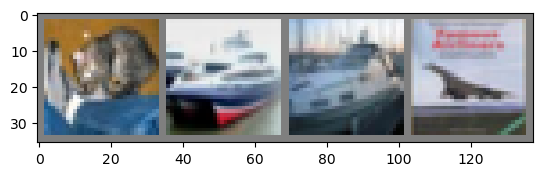

GroundTruth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # Tensor를 numpy 배열로 변환
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # numpy 배열의 차원 순서를 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경하여 이미지로 표시
    plt.show()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1) # torch.max는 주어진 텐서에서 최대값과 그 인덱스를 반환하는 함수입니다. _: 최대값, predicted: 최대값의 인덱스.


print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  plane


In [ ]:
# 전체 데이터 셋에서 확인
correct = 0 # 맞게 예측한 이미지의 수
total = 0  # 전체 이미지의 수
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad(): # torch.no_grad()는 autograd 엔진을 비활성화하여, 연산이 수행되는 동안 메모리를 절약하고 계산 속도를 높이는 역할을 합니다.
                      # with는 특정 블록의 코드가 실행되는 동안 일시적으로 torch.no_grad()의 효과가 적용되도록 하는 컨텍스트 매니저입니다.
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [26]:
# 각 분류 별로 얼마나 잘 맞췄는지 확인
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1) # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택
                                               # _: 최대값, predictions: 최대값의 인덱스 
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 56.7 %
Accuracy for class: car   is 72.3 %
Accuracy for class: bird  is 43.6 %
Accuracy for class: cat   is 42.0 %
Accuracy for class: deer  is 44.4 %
Accuracy for class: dog   is 22.5 %
Accuracy for class: frog  is 74.3 %
Accuracy for class: horse is 51.2 %
Accuracy for class: ship  is 82.2 %
Accuracy for class: truck is 67.3 %
